<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile tools.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import time
import json
from copy import deepcopy

plt.rc('font', size=30)  # controls default text sizes
plt.rc('axes', titlesize=25)  # fontsize of the axes title
plt.rc('axes', labelsize=25)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=17)  # fontsize of the tick labels
plt.rc('ytick', labelsize=17)  # fontsize of the tick labels
plt.rc('legend', fontsize=20)  # legend fontsize
plt.rc('figure', titlesize=30)
plt.tight_layout()


def plot(V, pi):
    # plot value
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))
    ax1.axis('on')
    ax1.cla()
    states = np.arange(V.shape[0])
    ax1.bar(states, V, edgecolor='none')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value', rotation='horizontal', ha='right')
    ax1.set_title('Value Function')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax1.yaxis.grid()
    ax1.set_ylim(bottom=V.min())
    # plot policy
    ax2.axis('on')
    ax2.cla()
    im = ax2.imshow(pi.T, cmap='Greys', vmin=0, vmax=1, aspect='auto')
    ax2.invert_yaxis()
    ax2.set_xlabel('State')
    ax2.set_ylabel('Action', rotation='horizontal', ha='right')
    ax2.set_title('Policy')
    start, end = ax2.get_xlim()
    ax2.xaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    start, end = ax2.get_ylim()
    ax2.yaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.grid(which='minor')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.20)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Probability', rotation=0, ha='left')
    fig.subplots_adjust(wspace=0.5)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.001)
    plt.close()


class ParkingWorld:
    def __init__(self,
                 num_spaces=10,
                 num_prices=4,
                 price_factor=0.1,
                 occupants_factor=1.0,
                 null_factor=1 / 3):
        self.__num_spaces = num_spaces
        self.__num_prices = num_prices
        self.__occupants_factor = occupants_factor
        self.__price_factor = price_factor
        self.__null_factor = null_factor
        self.__S = [num_occupied for num_occupied in range(num_spaces + 1)]
        self.__A = list(range(num_prices))


    def transitions(self, s, a):
        return np.array([[r, self.p(s_, r, s, a)] for s_, r in self.support(s, a)])

    def support(self, s, a):
        return [(s_, self.reward(s, s_)) for s_ in self.__S]

    def p(self, s_, r, s, a):
        if r != self.reward(s, s_):
            return 0
        else:
            center = (1 - self.__price_factor
                      ) * s + self.__price_factor * self.__num_spaces * (
                          1 - a / self.__num_prices)
            emphasis = np.exp(
                -abs(np.arange(2 * self.__num_spaces) - center) / 5)
            if s_ == self.__num_spaces:
                return sum(emphasis[s_:]) / sum(emphasis)
            return emphasis[s_] / sum(emphasis)

    def reward(self, s, s_):
        return self.state_reward(s) + self.state_reward(s_)

    def state_reward(self, s):
        if s == self.__num_spaces:
            return self.__null_factor * s * self.__occupants_factor
        else:
            return s * self.__occupants_factor

    def random_state(self):
        return np.random.randint(self.__num_prices)

    def step(self, s, a):
        probabilities = [
            self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S
        ]
        return np.random.choice(self.__S, p=probabilities)

    @property
    def A(self):
        return list(self.__A)

    @property
    def num_spaces(self):
        return self.__num_spaces

    @property
    def num_prices(self):
        return self.num_prices

    @property
    def S(self):
        return list(self.__S)


class Transitions(list):
    def __init__(self, transitions):
        self.__transitions = transitions
        super().__init__(transitions)

    def __repr__(self):
        repr = '{:<14} {:<10} {:<10}'.format('Next State', 'Reward',
                                             'Probability')
        repr += '\n'
        for i, (s, r, p) in enumerate(self.__transitions):
            repr += '{:<14} {:<10} {:<10}'.format(s, round(r, 2), round(p, 2))
            if i != len(self.__transitions) - 1:
                repr += '\n'
        return repr

Writing tools.py


In [ ]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import tools

As might be expected, charging a high price is likely to decrease occupancy over the hour, while charging a low price is likely to increase it.

an environment with three parking spaces and three price points. Note that an environment with three parking spaces actually has four states — zero, one, two, or three spaces could be occupied.

In [ ]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1,num_prices)) / num_prices

In [ ]:
V

array([0., 0., 0., 0.])

In [ ]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [ ]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


In [ ]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [ ]:
state = 0
action = 1
pi[state, action]

0.3333333333333333

In [ ]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [ ]:
for s, pi_s in enumerate(pi):
   print(''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.21    pi(A=2|S=0) = 0.04    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


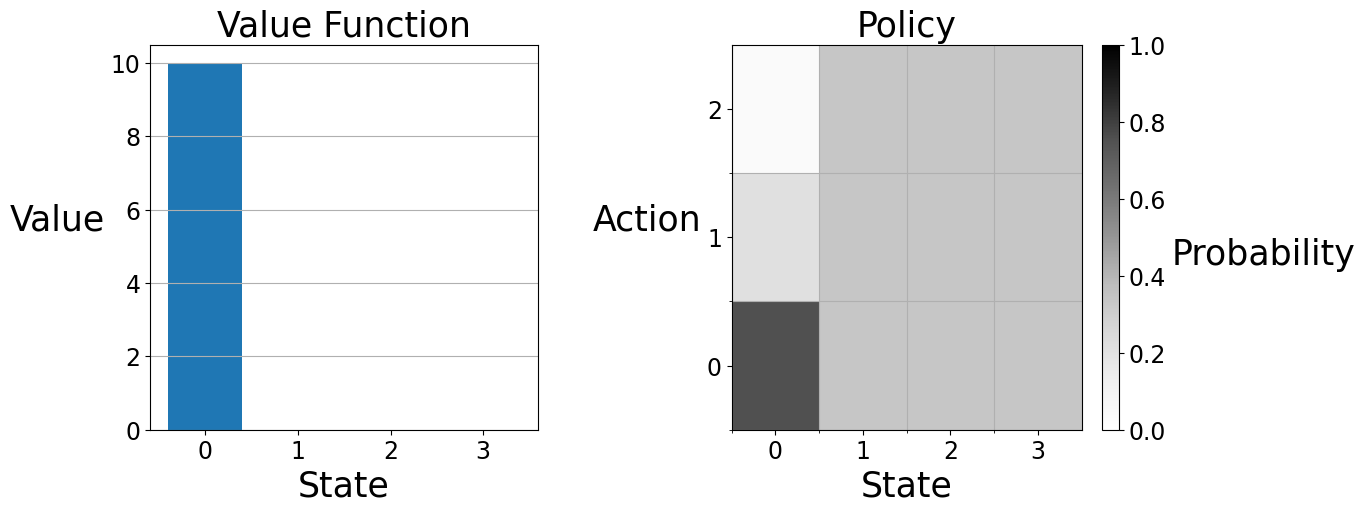

In [ ]:
tools.plot(V, pi)

 On the left, the value function is displayed as a barplot. State zero has an expected return of ten, while the other states have an expected return of zero.

 on the right, the policy is displayed on a two-dimensional grid. In state zero, action zero is the darkest because the agent's policy makes this choice with the highest probability. In the other states the agent has the equiprobable policy, so the vertical strips are colored uniformly.

In [ ]:
env.S

[0, 1, 2, 3]

In [ ]:
env.A

[0, 1, 2]

The method takes a state and an action and returns a 2-dimensional array, where the entry at (i,0) is the reward for transitioning to state from the current state and the entry at (i,1) is the conditional probability of transitioning to state given the current state and action.

In [ ]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [ ]:
for s_, (r, p) in enumerate(transitions):
  print(f'P(S={s_}, R={r} | S = {state}, A = {action}) = {p.round(2)}')

P(S=0, R=1.0 | S = 3, A = 1) = 0.12
P(S=1, R=2.0 | S = 3, A = 1) = 0.15
P(S=2, R=3.0 | S = 3, A = 1) = 0.18
P(S=3, R=2.0 | S = 3, A = 1) = 0.54


#Policy Evaluation

## Section 1: Policy Evaluation

 the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook.

We have written an outline of the policy evaluation algorithm described in chapter 4.1 of the textbook. It is left to you to fill in the `bellman_update` function to complete the algorithm.

In [ ]:
def evaluate_policy(env, V, pi, gamma, theta):
  while True:
    delta = 0
    for s in env.S:
      v = V[s]
      bellman_update(env,V,pi,s,gamma)
      delta = max(delta,abs(v-V[s]))
    if delta < theta:
      break
    return V

In [ ]:
def bellman_update(env,V,pi,s,gamma):
  v = 0
  for action in env.A:
    action_prob = pi[s][action]
    transitions = env.transitions(s,action)
    for next_state in env.S:
      reward = transitions[next_state,0]
      prob = transitions[next_state,1]
      v += action_prob * prob * (reward + gamma * V[next_state])
  V[s] = v

In [ ]:
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

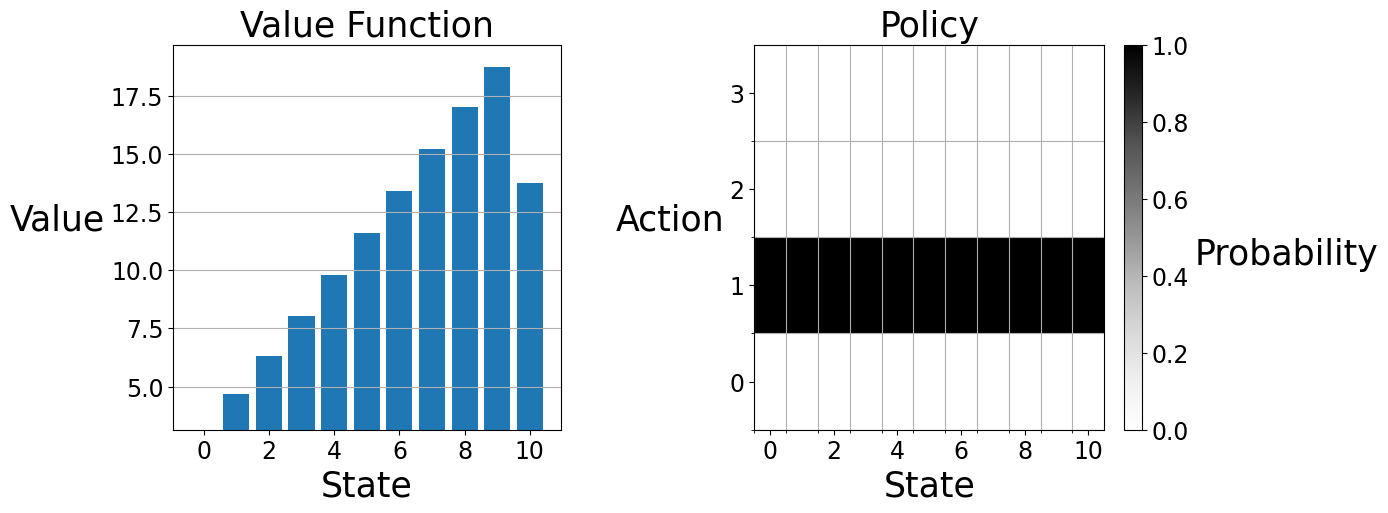

In [ ]:
tools.plot(V, city_policy)



You can check the output (rounded to one decimal place) against the answer below:
State Value

0 80.0

1 81.7

2 83.4

3 85.1

4 86.9

5 88.6

6 90.1

7 91.6

8 92.8

9 93.8

10 87.8

Observe that the value function qualitatively resembles the city council's preferences — it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided)


#Policy Iteration

Now the city council would like you to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function(policy improvement).

In [ ]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi


In [ ]:
def q_greedify_policy(env, V, pi, s, gamma):
    A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            A[action] += prob * (reward + gamma * V[next_state])
    best_action = np.argmax(A)
    pi[s] = np.eye(len(env.A))[best_action]

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

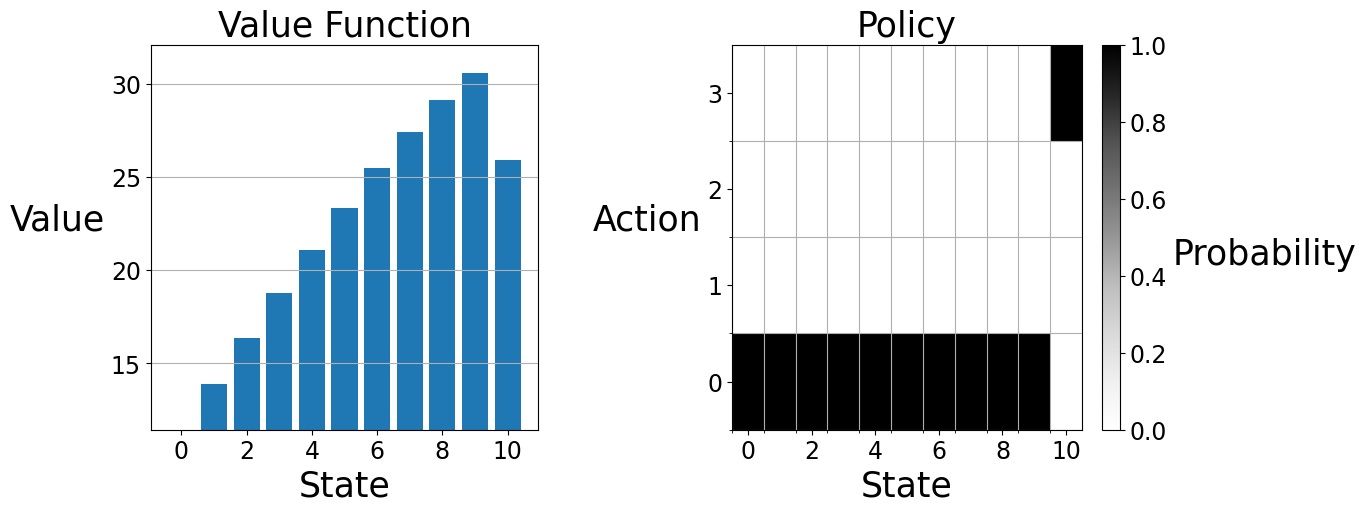

In [ ]:
tools.plot(V, pi)



You can check the value function (rounded to one decimal place) and policy against the answer below:

State Value Action

0 81.6 0

1 83.3 0

2 85.0 0

3 86.8 0

4 88.5 0

5 90.2 0

6 91.7 0

7 93.1 0

8 94.3 0

9 95.3 3

10 89.5 3

#Value Iteration

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$

In [ ]:
def value_iteration(env,gamma,theta):
  V = np.zeros(len(env.S))
  while True:
    delta = 0
    for s in env.S:
      v = V[s]
      bellman_optimality_update(env, V, s, gamma)
      delta = max(delta,abs(v - V[s]))
    if delta < theta:
      break
  pi = np.ones((len(env.S),len(env.A))) / len(env.A)
  for s in env.S:
    q_greedify_policy(env, V, pi, s, gamma)
  return V,pi

In [ ]:
def bellman_optimality_update(env, V, s, gamma):
  v = np.zeros(len(env.A))
  for action in env.A:
    transitions = env.transitions(s,action)
    for next_state in env.S:
      reward = transitions[next_state,0]
      prob = transitions[next_state,1]
      v[action] += prob * (reward + gamma * V[next_state])
  V[s] = np.max(v)

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

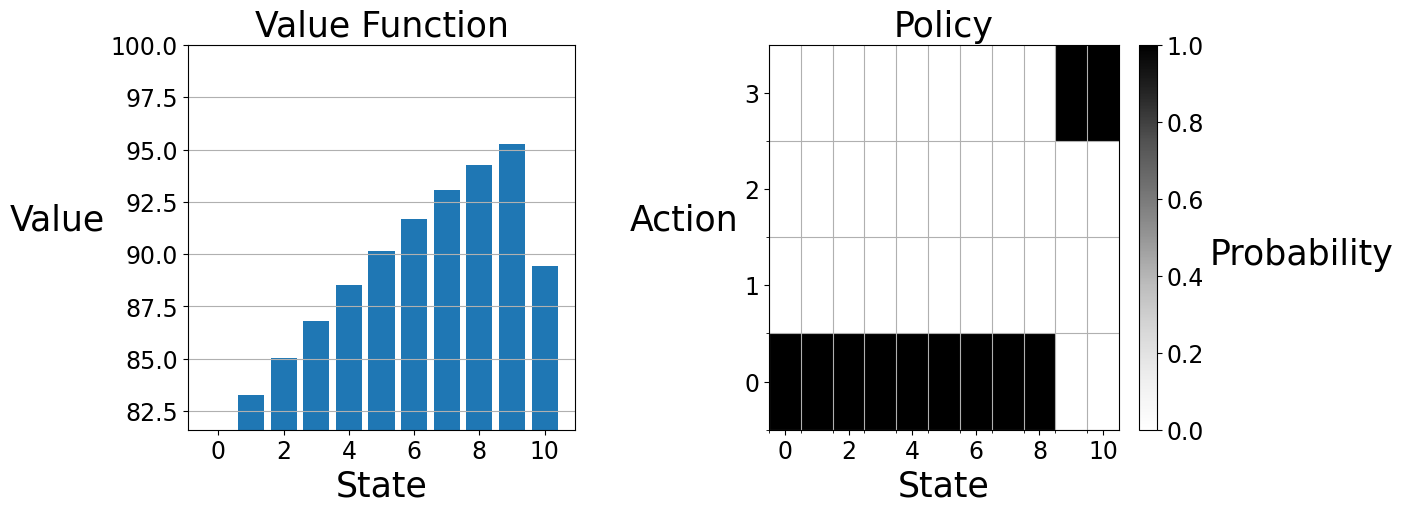

In [ ]:
tools.plot(V, pi)

State Value Action

0 81.6 0

1 83.3 0

2 85.0 0

3 86.8 0

4 88.5 0

5 90.2 0

6 91.7 0

7 93.1 0

8 94.3 0

9 95.3 3

10 89.5 3

#Asynchronous Methods

we've been working with synchronous algorithms, which update states in systematic sweeps. In contrast, asynchronous algorithms are free to update states in any order. Asynchronous algorithms can offer significant advantages in large MDPs, where even one synchronous sweep over the state space may be prohibitively expensive.



In [ ]:
def real_time_dynamic_programming(env, gamma, horizon):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    s = env.random_state()
    for t in range(horizon):
        real_time_dynamic_programming_helper(env, V, pi, s, gamma)
        a = np.random.choice(env.A, p=pi[s])
        s = env.step(s, a)
    return V, pi

In [ ]:
def real_time_dynamic_programming_helper(env, V, pi, s, gamma):
    q_greedify_policy(env, V, pi, s, gamma)
    bellman_optimality_update(env, V, s, gamma)

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
horizon = 500
np.random.seed(101)
V, pi = real_time_dynamic_programming(env, gamma, horizon)

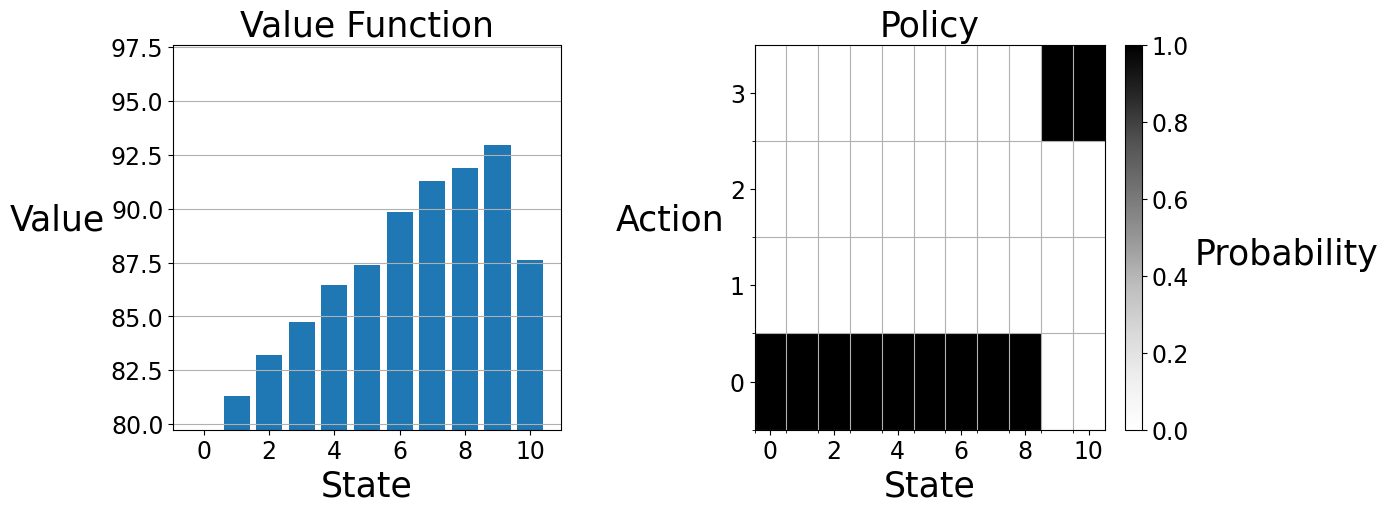

In [ ]:
tools.plot(V, pi)

State Value Action

0 79.7 0

1 81.3 0

2 83.2 0

3 84.7 0

4 86.5 0

5 87.4 0

6 89.8 0

7 91.3 0

8 91.9 0

9 93.0 3

10 87.63

Notice that these values differ from those of the synchronous methods we ran to convergence, indicating that the real-time dynamic programming algorithm needs more than 500 steps to converge. One takeaway from this result is that, while asychronous methods scale better to larger MDPs, they are not always the right choice — in small MDPs in which all states are visited frequently, such as the Gridworld City parking MDP, synchronous methods may offer better performance.